# Kalman Filter

The Kalman filter [1] and its variants, including but not limit to extended Kalman filter, ensemble Kalman filter [2], unscented Kalman filter [3], and cubature Kalman filter [4] are developed to sequentially update the probability distribution of states in  partially  observed  dynamics:



In the following, we will introduce different Kalman filter techniques to estimate the Gussian integrations.

1. R.E. Kalman, "A new approach to linear filtering and prediction problems".

2. G. Evensen, "Sequential data assimilation with a nonlinear quasi-geostrophic model using Monte Carlo methods to forecast error statistics".

3. S.J. Julier, J.K. Uhlmann, "Unscented filtering and nonlinear estimation".

4. I. Arasaratnam, S. Haykin, "Cubature kalman filters".

# Nonlinear Kalman Filters

Let denote Gaussian random variable $\theta \sim \mathcal{N}(m, C) \in \mathcal{R}^{N_{\theta}}$ and arbitrary functions $\mathcal{G}_i: \mathcal{R}^{N_{\theta}} \mapsto \mathcal{R}^{N_{y}}$, different nonlinear Kalman filters are designed to approximate the mean and covariance of $\theta$ under these nonlinear transforms:

$$\mathbb{E}\mathcal{G}_i(\theta) \quad \mathrm{Cov}(\mathcal{G}_1, \mathcal{G}_2)$$


## Extended Kalman Filter

Extended Kalman filter linearizes the functions $\mathcal{G}_i$, by means of the Taylor 
approximation of the first order:

$$\mathcal{G}_i(\theta) \approx \mathcal{G}_i(m) + d\mathcal{G}_i(m)(\theta - m)$$

And it approximates these integrals analytically:

$$ \begin{align*} 
&\mathbb{E}\mathcal{G}_i(\theta) = \mathcal{G}_i(m), \\
&\mathrm{Cov}(\mathcal{G}_1, \mathcal{G}_2) =  d\mathcal{G}_1(m)C d\mathcal{G}_2(m)^T
\end{align*}$$

However, extended Kalman filter requires gradient computation.

In [3]:
function ExKF(G::Function, m::Array{Float64,1}, C::Array{Float64,2})
    g, dg = G(m)
    mg, Cg = g, dg*C*dg'
    
    return mg, Cg
end

ExKF (generic function with 1 method)

## Unscented Kalman Filter

Unscented Kalman filter utilizes a deterministic quadrature rule to approximate these integrals.
This is the idea of the unscented transform [3] which we now define. 

* Let generate $2N_{\theta}+1$ symmetric sigma points deterministically:

    $$\begin{align*}
    \theta^0 &= m\\
    \theta^j &= m + c_j [\sqrt{C}]_j \quad (1\leq j\leq N_\theta)\\
    \theta^{j+N_\theta} &= m - c_j [\sqrt{C}]_j\quad (1\leq j\leq N_\theta)
    \end{align*}
    $$

    where $[\sqrt{C}]_j$ is the $j$th column of the Cholesky factor of $C$. 
    
    
* The quadrature rule approximates the mean and covariance of the transformed variable $\mathcal{G}_i(\theta)$ as follows,  
    
    $$\begin{align*}
    \mathbb{E}[\mathcal{G}_i(\theta)] \approx \mathcal{G}_i(\theta^0)\qquad 
    \mathrm{Cov}[\mathcal{G}_1(\theta),\mathcal{G}_2(\theta)]  \approx \sum_{j=1}^{2N_{\theta}} W_j^{c} \Big(\mathcal{G}_1(\theta^j) - \mathbb{E}\mathcal{G}_1(\theta)\Big)\Big(\mathcal{G}_2(\theta^j) - \mathbb{E}\mathcal{G}_2(\theta)\Big)^T 
    \end{align*}
    $$
    
    Here these constant weights are 
    
    $$
    \begin{align*}
    &c_j = \sqrt{N_\theta +\lambda} \qquad W_j^{c} = \frac{1}{2(N_\theta+\lambda)}~(j=1,\cdots,2N_{\theta}).\\
    &\lambda = a^2 (N_\theta + \kappa) - N_\theta \quad a=\min\{\sqrt{\frac{4}{N_\theta + \kappa}},  1\}\quad  \kappa = 0\\
    \end{align*}
    $$
    

This unscented transform is different from the original unscented transform. The modification we employ here replaces the original 2nd-order approximation of the $\mathbb{E}[\mathcal{G}_i(\theta)]$ with its 1st-order counterpart. We do this to avoid negative weights; it also has ramifications for the optimization process. Finally we mention that our modified unscented transform retains the
properties of exactness for mean and covariance under arbitrary linear transformations $\mathcal{G}_1$ and $\mathcal{G}_2$. 



In [4]:
using LinearAlgebra

function UKF(G::Function, m::Array{Float64,1}, C::Array{Float64,2})
    N_θ = length(m)
    N_ens = 2N_θ + 1
    
    # weights
    κ = 0.0
    a = min(sqrt(4/(N_θ + κ)), 1.0)
    λ = a^2*(N_θ + κ) - N_θ
    sigma_weight = sqrt(N_θ + λ)
    cov_weight = 1/(2(N_θ + λ))
    
    # generate sigma points
    chol_C = cholesky(Hermitian(C)).L
    θ = zeros(Float64, N_θ, N_ens)
    θ[:, 1] = m
    for i = 1: N_θ
        θ[:, i+1] = m + sigma_weight*chol_C[:,i]
        θ[:, i+1+N_θ] = m - sigma_weight*chol_C[:,i]
    end
    
    g = zeros(Float64, N_θ, N_ens)
    for i = 1: 2N_θ+1
        g[:, i], _ = G(θ[:, i])
    end
    
    # compute mean 
    mg = g[:, 1]
    
    Cg = zeros(Float64, N_θ, N_θ)
    for i = 1: N_ens
        Cg .+= cov_weight*(g[:, i] - mg)*(g[:, i] - mg)'
    end
    
    return mg, Cg 
end

UKF (generic function with 1 method)

## Ensemble Kalman Filter (Monte Carlo Kalman Filter)
Ensemble Kalman Filter utilizes Monte Carlo sampling to approximate these integrals. 
Let draw samples $\{\theta^j\}_{j=1}^{J}$ from $\mathcal{N}(m, C)$, the mean and covariance of the transformed variables are

$$ 
\begin{align*} 
&\mathbb{E}\mathcal{G}_i(\theta) = \frac{1}{J}\sum_{j=1}^J\mathcal{G}_i(\theta^j), \\
&\mathrm{Cov}(\mathcal{G}_1, \mathcal{G}_2) = \frac{1}{J-1}\sum_{j=1}^J\Big(\mathcal{G}_1(\theta^j) - \mathbb{E}\mathcal{G}_1(\theta)\Big)\Big(\mathcal{G}_2(\theta^j) - \mathbb{E}\mathcal{G}_2(\theta)\Big)^T
\end{align*}
$$


However, ensemble Kalman filter does not take advantage of the Gaussian information, and the performance might be sensitive to the ensemble size $J$.



In [7]:
using Random, Distributions
function EKF(G::Function, m::Array{Float64,1}, C::Array{Float64,2}, J::Int64)
    N_θ = length(m)
    
    θ = rand(MvNormal(m, C), J)

    g = zeros(Float64, N_θ, J)
    for i = 1: J
        g[:, i], _ = G(θ[:, i])
    end
    
    
    mg = sum(g, dims=2)/J
    
    Cg = zeros(Float64, N_θ, N_θ)
    for i = 1: J
        Cg .+= (g[:, i] - mg)*(g[:, i] - mg)'
    end
    Cg ./= (J - 1)
    
    return mg, Cg, g

end

EKF (generic function with 1 method)

In [8]:
import Pkg; Pkg.add("Distributions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


## Cubature Kalman Filter

Cubature Kalman filter utilizes a deterministic quadrature rule to approximate these integrals.
Its basic idea is to decompose the integration in the radial and spherical directions. The idea of the spherical-radial transformation is originated in [4]. 

For a Gaussian integration, we have 
\begin{align*}
\int g(\theta) \mathcal{N}(\theta; \mu, \Sigma) d\theta = \frac{1}{\sqrt{\pi^{n}}}\int g(\sqrt{2\Sigma}x + \mu) \exp(-x^Tx)dx
\end{align*}
Here $\Sigma = \sqrt{\Sigma}\sqrt{\Sigma}^T$. Therefore, we consider an integral of the form 
\begin{align*}
I(f) = \int f(x)\exp(-x^Tx)dx
\end{align*}

In the spherical-radial transformation, the key step is a change of variable from the Cartesian vector $x \in R^n$ to a radius $r$ and direction vector $y \in R^n$, where $x=ry$ and $y^Ty = 1$. Then the integral can be rewirtten as 
\begin{align*}
I(f) = \int_0^{\infty}\int_{U_n} f(ry)d\sigma(y)r^{n-1}\exp(-r^2)dr \qquad U_n \textrm{ is the unit sphere.} 
\end{align*}

### spherical integral
The spherical integral is approximated as 
\begin{align*}
S(r) = \int_{U_n} f(ry)d\sigma(y) \approx w\sum_{i=1}^{2n}f(r u_i)
\end{align*}
here $u_i = ue_i$ and $u_{i+n} = -ue_i$. 
Since $\{u_i\}$ is invariant under permutations and sign changes, the spherical integral is exact for odd-degree polynomials. In order that this rule is exact for all monomials of degree up to 3, we require that
\begin{align*}
&2nw = \int_{U_n}d\sigma(y) = A_n \qquad (f(ry) = 1) \\
&2wu^2 = \int_{U_n} y_1^2 d\sigma(y) = \frac{A_n}{n} \qquad (f(ry) = y_1^2)
\end{align*}
Here $A_n = \frac{2\sqrt{\pi^n}}{\Gamma(\frac{n}{2})}$. Therefore, 
\begin{align*}
u = 1\qquad w = \frac{A_n}{2n}. 
\end{align*}

### radial integral
Bringing the definition of $S(r)$, we have 
\begin{align*}
I(f) = \int_0^{\infty} S(r) r^{n-1}\exp(-r^2)dr \approx w_1 S(r_1)
\end{align*}
Therefore, the well-known generalized Gaussian-Laguerre quadrature rule for approximating $\frac{1}{2}\int_0^{\infty} S(\sqrt{t}) t^{\frac{n-2}{2}}\exp(-t)dt$ is applied. Since the spherical integral vanishes for odd-degree polynomials, we will focus on $S(r)$ with an even degree. Here we consider first-degree Gauss-Laguerre rule with $w_1=\frac{\Gamma(\frac{n}{2})}{2}$ and $r_1 = \sqrt{n/2}$.

### Summary
Therefore, the third order spherical-radial transformation (cubature transformation) becomes
\begin{align*}
    I(f) = w_1w\sum_{i=1}^{2n}f(r_1 u_i) = \frac{\sqrt{\pi^n}}{2n}\sum_{i=1}^{2n}f(\sqrt{\frac{n}{2}} e_i)
\end{align*}

\begin{align*}
\int g(\theta) \mathcal{N}(\theta; \mu, \Sigma) d\theta = \frac{1}{\sqrt{\pi^{n}}} \int g(\sqrt{2\Sigma}x + \mu) \exp(-x^Tx)dx = \frac{1}{2n}\sum_{i=1}^{2n}
g(\sqrt{n} \sqrt{\Sigma} e_i + \mu)
\end{align*}
Here $\sqrt{\Sigma}$ is the lower triangular Cholesky factor which satisfies $\Sigma = \sqrt{\Sigma}\sqrt{\Sigma}^T$.

In [11]:
using LinearAlgebra

function CKF(G::Function, m::Array{Float64,1}, C::Array{Float64,2})
    N_θ = length(m)
    N_ens = 2N_θ
    
    
    # generate sigma points
    chol_C = cholesky(Hermitian(C)).L
    θ = zeros(Float64, N_θ, N_ens)
    for i = 1: N_θ
        θ[:, i]     = m + sqrt(N_θ)*chol_C[:,i]
        θ[:, i+N_θ] = m - sqrt(N_θ)*chol_C[:,i]
    end
    
    g = zeros(Float64, N_θ, N_ens)
    for i = 1: N_ens
        g[:, i], _ = G(θ[:, i])
    end
    
    # compute mean 
    mg = zeros(Float64, N_θ)
    for i = 1: N_ens
        mg .+= 1/N_ens*g[:, i]
    end
    
    # compute covariance
    Cg = zeros(Float64, N_θ, N_θ)
    for i = 1: N_ens
        Cg .+= 1/N_ens*(g[:, i] - mg)*(g[:, i] - mg)'
    end
    
    return mg, Cg 
end

CKF (generic function with 1 method)

# Numerical Example
Consider the following 2-dimensional example:


$$
\theta \sim \mathcal{N}\Big(\begin{bmatrix} 10 \\ 10 \end{bmatrix}, 
\begin{bmatrix} 1^2 & 0\\ 0 & 1^2 \end{bmatrix}\Big)
$$
here the covariance roughly represents $10\%$ error, which is the case for most inverse problems. 

$$\mathcal{G}(\theta) = \begin{bmatrix} 1 + \sqrt{\theta_{(1)}^2 + \theta_{(2)}^2} \\
                 e^{\frac{\theta_{(1)}}{2}} + \theta_{(2)}^3 \end{bmatrix}$$ 
                 
The distributions of $\mathcal{G}(\theta)$ obtained by different Kalman filters are visualized, the grey dots represent the "true" distribution obtained by the Monte Carlo method.

┌ Info: mean estimation: 
│ MCKF: [15.169185425149905; 1193.0230232072893;;] 
│ ExKF: [15.142135623730951, 1148.4131591025766] 
│ UKF: [15.142135623730951, 1148.4131591025766] 
│ EKF: [15.239060601472158; 1161.9762237979367;;] 
└ CKF: [15.17762320965705, 1197.750787949815]
┌ Info: cov estimation:  
│ MCKF: [0.9695779577098924 268.77518463203353; 268.77518463203353 100898.6240228958] 
│ ExKF: [0.9999999999999998 264.6040099653392; 264.6040099653392 95506.61644870168] 
│ UKF: [0.9962594937486138 271.575304310355; 271.575304310355 100239.69273127784] 
│ EKF: [0.6573084163306175 181.30406428574307; 181.30406428574307 75111.62555421474] 
└ CKF: [0.9950001249937515 269.82443096724865; 269.82443096724865 97805.49111101]


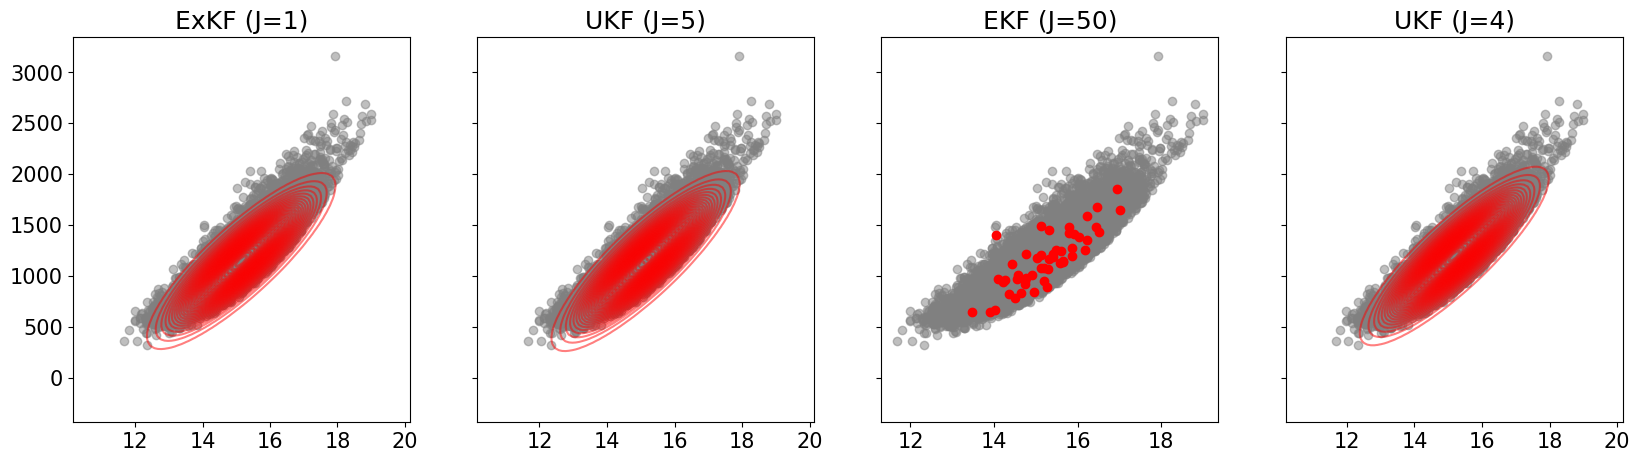

In [12]:
include("../Inversion/Plot.jl")
function G(θ)
    g = [1 + sqrt(θ[1]^2 + θ[2]^2); exp(θ[1]/2) + θ[2]^3]
    dg = [θ[1]/(sqrt(θ[1]^2 + θ[2]^2)) θ[2]/(sqrt(θ[1]^2 + θ[2]^2)); 
          exp(θ[1]/2)/2                3θ[2]^2]
    return g, dg
end

m, C = [10.0; 10.0], [1.0^2 0.0; 0.0 1.0^2]

mckf = EKF(G, m, C, 10000)
exkf = ExKF(G, m, C)
ukf = UKF(G, m, C)
ekf = EKF(G, m, C, 50)
ckf = CKF(G, m, C)


Nx = Ny = 100 

fig, ax = PyPlot.subplots(ncols=4, sharex=false, sharey=true, figsize=(20,5))
for i = 1:4
    ax[i].scatter(mckf[3][1, :], mckf[3][2, :], color = "grey", alpha=0.5, label = "MCMC")
end

X,Y,Z = Gaussian_2d(exkf[1], exkf[2], Nx, Ny)
ax[1].contour(X, Y, Z, 50, colors = "red", alpha=0.5, label = "ExKF (J=1)")
ax[1].set_title("ExKF (J=1)")

X,Y,Z = Gaussian_2d(ukf[1], ukf[2], Nx, Ny)
ax[2].contour(X, Y, Z, 50, colors = "red", alpha=0.5, label = "UKF (J=5)")
ax[2].set_title("UKF (J=5)")

ax[3].scatter(ekf[3][1, :], ekf[3][2, :], color = "red", label = "EKF")
ax[3].set_title("EKF (J=50)")

X,Y,Z = Gaussian_2d(ckf[1], ckf[2], Nx, Ny)
ax[4].contour(X, Y, Z, 50, colors = "red", alpha=0.5, label = "CKF (J=4)")
ax[4].set_title("UKF (J=4)")

@info "mean estimation: \nMCKF: $(mckf[1]) \nExKF: $(exkf[1]) \nUKF: $(ukf[1]) \nEKF: $(ekf[1]) \nCKF: $(ckf[1])"

@info "cov estimation:  \nMCKF: $(mckf[2]) \nExKF: $(exkf[2]) \nUKF: $(ukf[2]) \nEKF: $(ekf[2]) \nCKF: $(ckf[2])"
